In [10]:
import tensorflow as tf
import os.path as osp
from analysis import analysis_data
import pandas as pd

In [11]:
predictions_path = osp.join(osp.dirname(analysis_data.__file__), "pred_consumption_predictions.csv")
df_predictions = pd.read_csv(predictions_path)
df_predictions.columns = ["agent_id", "timestep", "predicted_load", "predicted_solar"]
# df_predictions

In [12]:
pred_data_path = osp.join(osp.dirname(analysis_data.__file__), "pred_performance.csv")
df_pred_performance = pd.read_csv(pred_data_path)
col_names = ["agent_id",
            "action",
            "electrical_storage_soc",
            "net_electricity_consumption",
            "non_shiftable_load",
            "solar_generation",
            "carbon_intensity",
            "electricity_pricing"]

df_pred_performance.columns = col_names
# df_pred_performance

In [13]:
df = pd.concat([df_predictions, df_pred_performance.drop(["agent_id"], axis=1)], axis=1)
df["predicted_load_error"] = df["predicted_load"] - df["non_shiftable_load"].shift(-1, fill_value=0.0)
df_orig = df.copy()

In [15]:
include_columns = ["predicted_load", "predicted_solar", "action", "electrical_storage_soc", "non_shiftable_load", "solar_generation", "carbon_intensity", "predicted_load_error"]
df = df[[x for x in df.columns if x in include_columns]]
df

,predicted_load,predicted_solar,action,electrical_storage_soc,non_shiftable_load,solar_generation,carbon_intensity,predicted_load_error
0,2.360010,-0.008032,-0.031749,0.240058,9.918213e-08,0.0,0.175584,2.360010
1,2.081728,-0.009476,-0.075234,0.240058,9.918213e-08,0.0,0.175584,0.149653
2,2.931047,-0.009840,-0.172681,0.240058,1.932075e+00,0.0,0.175584,2.640964
3,1.246601,-0.004545,-0.033845,0.240058,2.900833e-01,0.0,0.175584,0.413251
4,-0.764007,-0.004221,0.118720,0.502107,8.333500e-01,0.0,0.170252,-0.764007
...,...,...,...,...,...,...,...,...
43424,2.623995,0.005493,-0.018483,0.020288,3.151700e+00,0.0,0.215501,0.429362
43425,1.918158,-0.003758,-0.097655,0.218557,2.194633e+00,0.0,0.215501,0.755274
43426,1.103488,-0.002029,-0.139856,0.292594,1.162883e+00,0.0,0.215501,-0.082996
43427,2.153426,-0.003498,0.000000,0.000000,1.186483e+00,0.0,0.215501,-0.001590


[18:02:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




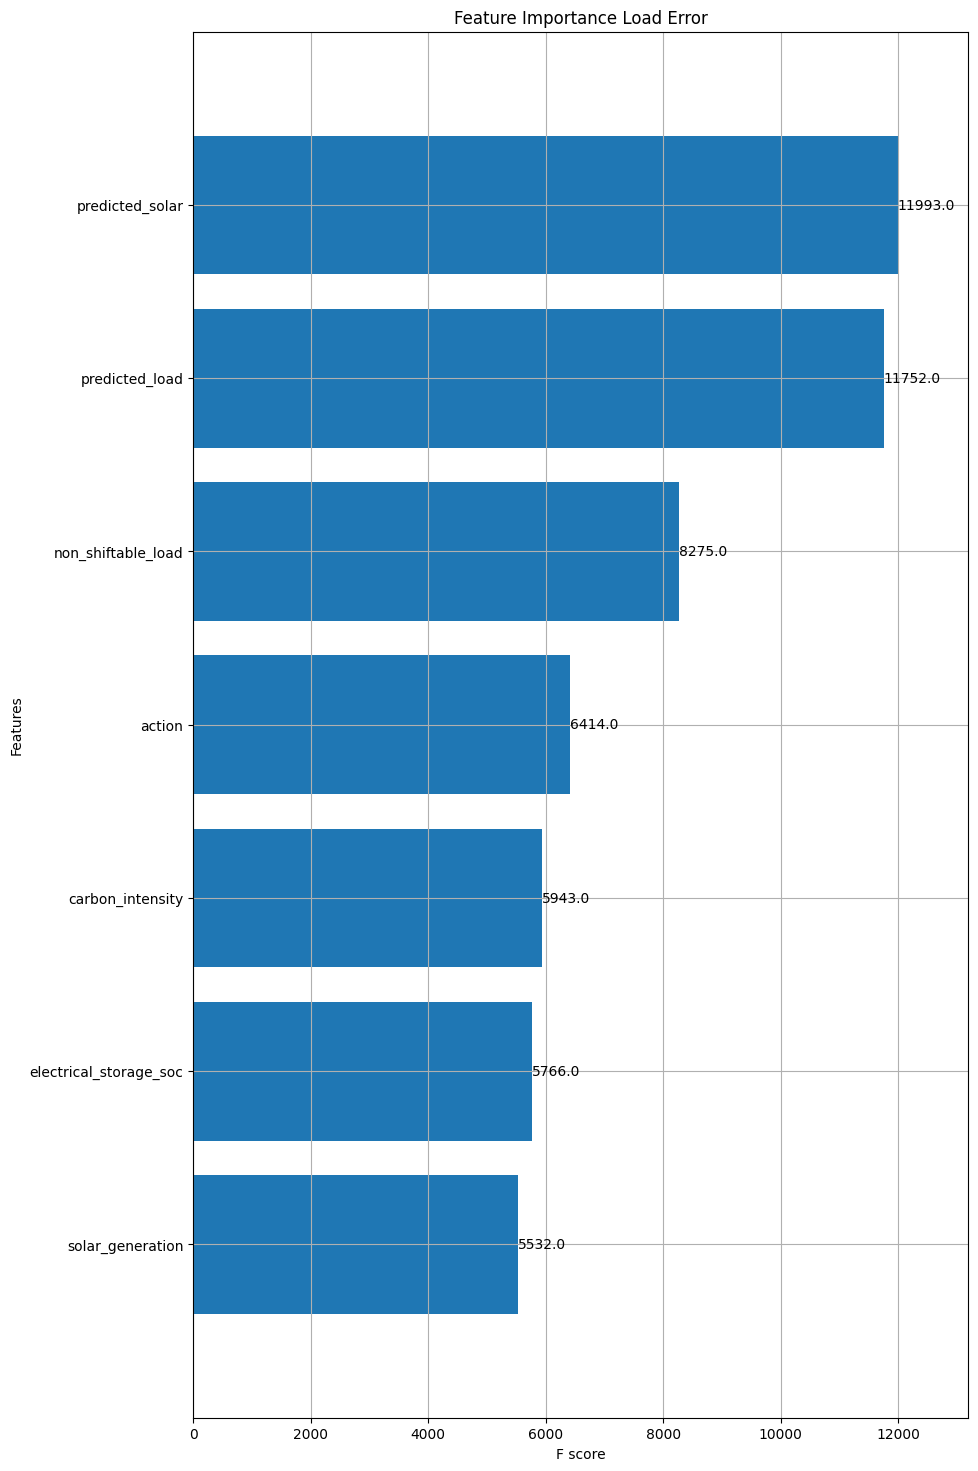

In [16]:
import pandas as pd
import data.citylearn_challenge_2022_phase_1 as competition_data
import os.path as osp
import xgboost as xgb
from matplotlib import pyplot as plt


train_y = df["predicted_load_error"]
train_X = df.drop(["predicted_load_error"], axis=1)
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
remain_num = 99


fig, ax = plt.subplots(figsize=(10,18))
xgb.plot_importance(model, max_num_features=remain_num, height=0.8, ax=ax, title="Feature Importance Load Error")
plt.show()

In [44]:
df = df_orig
df = df.loc[df["agent_id"] == 1]
df = df[[x for x in df.columns if x in include_columns]]
df = df.reset_index().drop(["index"], axis=1)
df.head()

,predicted_load,predicted_solar,action,electrical_storage_soc,non_shiftable_load,solar_generation,carbon_intensity,predicted_load_error
0,2.360010,-0.008032,-0.031749,0.240058,9.918213e-08,0.0,0.175584,2.360010
1,3.238225,-0.008032,-0.174060,0.205210,9.918213e-08,0.0,0.170252,3.238224
2,2.361422,-0.008032,0.000000,0.014154,9.918213e-08,0.0,0.158084,2.361422
3,2.713470,-0.008032,-0.012895,0.014154,9.918213e-08,0.0,0.156934,2.713470
4,1.673726,-0.002512,0.000000,0.000000,9.921392e-08,0.0,0.160846,1.673726


In [45]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=df.predicted_load_error)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 24
Number of observations used for backtesting: 8662
    Number of folds: 8662
    Number of steps per fold: 1

Data partition in fold: 0
    Training:   0 -- 23  (n=24)
    Validation: 24 -- 24  (n=1)
Data partition in fold: 1
    Training:   0 -- 23  (n=24)
    Validation: 25 -- 25  (n=1)
Data partition in fold: 2
    Training:   0 -- 23  (n=24)
    Validation: 26 -- 26  (n=1)
Data partition in fold: 3
    Training:   0 -- 23  (n=24)
    Validation: 27 -- 27  (n=1)
Data partition in fold: 4
    Training:   0 -- 23  (n=24)
    Validation: 28 -- 28  (n=1)
Data partition in fold: 5
    Training:   0 -- 23  (n=24)
    Validation: 29 -- 29  (n=1)
Data partition in fold: 6
    Training:   0 -- 23  (n=24)
    Validation: 30 -- 30  (n=1)
Data partition in fold: 7
    Training:   0 -- 23  (n=24)
    Validation: 31 -- 31  (n=1)
Data partition in fold: 8
    Training:   0 -- 2

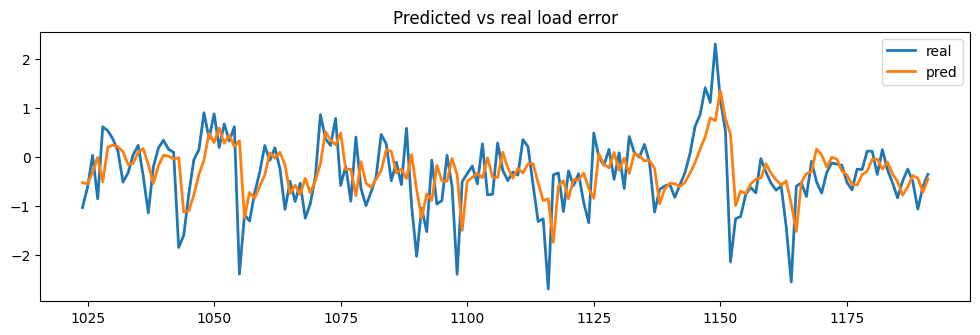

In [46]:
from matplotlib import pyplot as plt
from skforecast.model_selection import backtesting_forecaster

metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df.predicted_load_error,
                          initial_train_size = None,
                          fixed_train_size   = False,
                          steps              = 1,
                          metric             = 'mean_squared_error',
                          refit              = False,
                          verbose            = True
                      )

fig, ax = plt.subplots(figsize=(12, 3.5))
df.loc[predictions[1000:1168].index, 'predicted_load_error'].plot(ax=ax, linewidth=2, label='real')
predictions[1000:1168].plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Predicted vs real load error')
ax.legend();

In [47]:
# Lags used as predictors
lags_grid = [ [1], [1, 2], [1, 2, 3], [1, 2, 3, 4], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7, 8], [1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 25], [1, 2, 25, 26], [1, 2, 3, 25, 26, 27], [1, 2, 3, 4, 25, 26, 27, 28], [1, 2, 3, 4, 5, 25, 26, 27, 28, 29], [1, 2, 3, 4, 5, 6, 25, 26, 27, 28, 29, 30], [1, 2, 3, 4, 5, 6, 7, 25, 26, 27, 28, 29, 30, 31], [1, 2, 3, 4, 5, 6, 7, 8, 25, 26, 27, 28, 29, 30, 31, 32], [1, 2, 3, 4, 5, 6, 7, 8, 9, 25, 26, 27, 28, 29, 30, 31, 32, 33], [1, 25, 49], [1, 2, 25, 26, 49, 50], [1, 2, 3, 25, 26, 27, 49, 50, 51], [1, 2, 3, 4, 25, 26, 27, 28, 49, 50, 51, 52], [1, 2, 3, 4, 5, 25, 26, 27, 28, 29, 49, 50, 51, 52, 53], [1, 2, 3, 4, 5, 6, 25, 26, 27, 28, 29, 30, 49, 50, 51, 52, 53, 54], [1, 2, 3, 4, 5, 6, 7, 25, 26, 27, 28, 29, 30, 31, 49, 50, 51, 52, 53, 54, 55], [1, 2, 3, 4, 5, 6, 7, 8, 25, 26, 27, 28, 29, 30, 31, 32, 49, 50, 51, 52, 53, 54, 55, 56], [1, 2, 3, 4, 5, 6, 7, 8, 9, 25, 26, 27, 28, 29, 30, 31, 32, 33, 49, 50, 51, 52, 53, 54, 55, 56, 57]]

# Regressor's hyperparameters
param_grid = {'alpha': np.logspace(-3, 5, 10),
              'tol': np.logspace(-1, -10, 10),
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}


results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = df.predicted_load_error,
                   param_grid         = {},
                   lags_grid          = lags_grid,
                   steps              = 1,
                   metric             = 'mean_squared_error',
                   refit              = False,
                   initial_train_size = len(df) - 1,
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )
results_grid

Number of models compared: 27.


loop param_grid:   0%|                                              | 0/1 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/1 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/1 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/1 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/1 [00:00<?, ?it/s]
                                                                                          
loop param_grid:   0%|                                              | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1 25] 
  Parameters: {}
  Backtesting metric: 0.22515739948001093



,lags,params,mean_squared_error
9,"[1, 25]",{},0.225157
18,"[1, 25, 49]",{},0.239350
0,[1],{},0.247912
10,"[1, 2, 25, 26]",{},0.259956
19,"[1, 2, 25, 26, 49, 50]",{},0.270931
1,"[1, 2]",{},0.290528
11,"[1, 2, 3, 25, 26, 27]",{},0.311102
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 25, 26, 27, 28, 29...",{},0.321040
24,"[1, 2, 3, 4, 5, 6, 7, 25, 26, 27, 28, 29, 30, ...",{},0.322313
15,"[1, 2, 3, 4, 5, 6, 7, 25, 26, 27, 28, 29, 30, 31]",{},0.324465


In [48]:
# 1: [1, 25]                                0.22 ns
# 2: [1, 2, 3, 4, 5, 6]                     0.2
# 3: [1, 2, 3, 4]                           0.12 st
# 4: [1]                                    10.44 nst
# 0: [1, 2, 3, 4, 5, 6, 7, 8, 9]            0.21 st
